# Trabajo Práctico Final - Simulación #

In [1]:
from Simulacion import *
from os import environ
from IPython.display import HTML
from IPython.display import display
import pickle
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows',None)


## Modelo de simulación ##
El modelo consta de los siguientes objetos:
* Grúa {Viajando a P1, Viajando a P2, Cargando P1, Cargando P2}
* Auto

Además, tenemos los siguientes eventos:
* Llegada auto P1
* Llegada auto P2
* Llegada a P1
* Llegada a P2
* Fin carga P1
* Fin carga P2
* Abandono



## Parámetros e interfaz ##

In [2]:
with open('param.pickle', 'rb') as handle:
    param = pickle.load(handle)

p_precio_auto_a = float(param['p_precio_auto_a'])
p_precio_auto_b = float(param['p_precio_auto_b'])
p_precio_abandono_a = float(param['p_precio_abandono_a'])
p_precio_abandono_b = float(param['p_precio_abandono_b'])
p_costo_grua_a = float(param['p_costo_grua_a'])
p_costo_grua_b = float(param['p_costo_grua_b'])
p_tiempo_grua_a = float(param['p_tiempo_grua_a'])
p_tiempo_grua_b = float(param['p_tiempo_grua_b'])
p_capac_grua_a = float(param['p_capac_grua_a'])
p_capac_grua_b = float(param['p_capac_grua_b'])
p_serv_min_a = float(param['p_serv_min_a'])
p_serv_min_b = float(param['p_serv_min_b'])
p_tiempo = float(param['p_tiempo'])
p_mostrar_desde = float(param['p_mostrar_desde'])
p_iteraciones = float(param['p_iteraciones'])

In [3]:
def View(df,num):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "' + num + '", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += 'win.document.title = "Simulación - Opción '+num+'";'
    s += '</script>'
    return(HTML(s+css))

## Simulación - Opción A##

En el ejercicio original, implica esperar a completar la grúa antes de empezar el traslado.

In [4]:
s1 = Simulacion(p_precio_auto_a,p_precio_abandono_a,p_costo_grua_a,p_tiempo,p_mostrar_desde,p_iteraciones,
     p_tiempo_grua_a,p_capac_grua_a,p_serv_min_a)
tabla_uno = s1.simular()

In [5]:
View(tabla_uno,"A")

## Simulación - Opción B##

En el ejercicio original, se espera sólo a tener cómo mínimo tres autos antes de que la grúa empiece el traslado.

In [6]:
s2 = Simulacion(p_precio_auto_b,p_precio_abandono_b,p_costo_grua_b,p_tiempo,p_mostrar_desde,p_iteraciones,
     p_tiempo_grua_b,p_capac_grua_b,p_serv_min_b)
tabla_dos = s2.simular()

In [7]:
View(tabla_dos,"B")

## Análisis y estadísticas ##

### Cantidad de abandonos ###
Podemos analizar la cantidad de abandonos durante el período de la simulación mostrada en el estado actual y con la mejora propuesta.

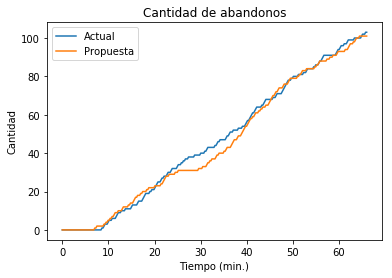

In [8]:
if p_iteraciones != '0':
    data_a=pd.DataFrame()
    data_a[["Reloj","Cont. Perdidos"]] = tabla_uno[["Reloj","Cont. Perdidos"]].copy()
    max_hora_a = data_a.loc[len(data_a)][0]

    data_b=pd.DataFrame()
    data_b[["Reloj","Cont. Perdidos"]] = tabla_dos[["Reloj","Cont. Perdidos"]].copy()
    max_hora_b = data_b.loc[len(data_b)][0]

    max_len = min(len(data_a),len(data_b))
    data_a = data_a[:][0:max_len]
    data_b = data_b[:][0:max_len]

    max_hora= min(max_hora_a,max_hora_b)

    X = np.linspace(float(p_mostrar_desde), max_hora,len(data_a),endpoint=True)
    plt.plot(X,data_a["Cont. Perdidos"],label='Actual')
    plt.plot(X,data_b["Cont. Perdidos"],label='Propuesta')
    plt.xlabel('Tiempo (min.)')
    plt.ylabel('Cantidad')
    plt.legend(loc='upper left')
    plt.title('Cantidad de abandonos')
    plt.show()

### Proporción de clientes que abandonan ###
Podemos analizar la cantidad de abandonos respecto con la cantidad de clientes bancarios que si se atienden, con las dos soluciones.


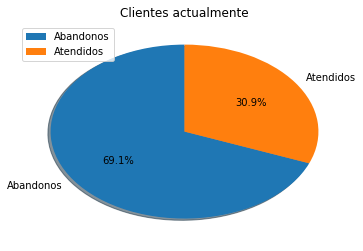

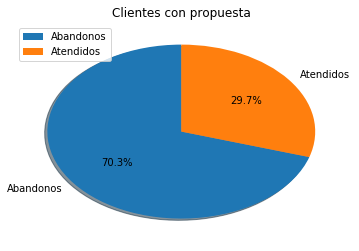

In [9]:
Z1 = [s1.cont_abandonos,s1.cont_atendidos]
Z2 = [s2.cont_abandonos,s2.cont_atendidos]
plt.pie(Z1,labels=("Abandonos","Atendidos"),autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.legend(loc='upper left')
plt.title('Clientes A')
plt.show()

plt.pie(Z2,labels=("Abandonos","Atendidos"), autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.legend(loc='upper left')
plt.title('Clientes B')
plt.show()

### Distribución de atención de clientes ###
Podemos analizar el promedio de permanencia de autos atendidos en cada cola respecto al tiempo.

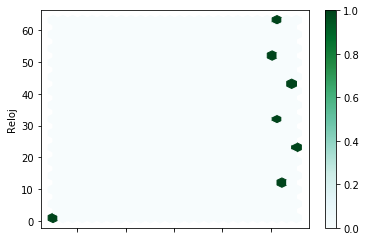

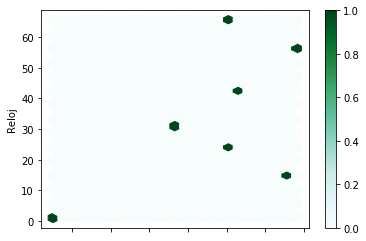

In [13]:
%matplotlib inline
if p_iteraciones != 0:
    cantidad = len(tabla_uno)-2
    data_raw = pd.DataFrame(np.ones((cantidad,2)), columns = ["Tiempo espera","Reloj"], index=range(1,len(tabla_uno)-1))
    index = 1
    i = 1
    while i<len(tabla_uno):
        temp = float(tabla_uno.loc[i+1][20]) - float(tabla_uno.loc[i][20])
        if temp > 0:
            data_raw.loc[index]["Tiempo espera"] = temp
            data_raw.loc[index]["Reloj"] = tabla_uno.loc[i+1]["Reloj"]
            index += 1
        i += 1
    data_raw = data_raw.loc[1:index]

    cantidad = len(tabla_dos)-2
    data_raw2 = pd.DataFrame(np.ones((cantidad,2)), columns = ["Tiempo espera","Reloj"], index=range(1,len(tabla_dos)-1))
    index = 1
    i = 1
    while i<len(tabla_dos):
        temp = float(tabla_dos.loc[i+1][20]) - float(tabla_dos.loc[i][20])
        if temp > 0:
            data_raw2.loc[index]["Tiempo espera"] = temp
            data_raw2.loc[index]["Reloj"] = tabla_dos.loc[i+1]["Reloj"]
            index += 1
        i += 1
    data_raw2 = data_raw2.loc[1:index]
       
    data_raw.plot.hexbin(x="Tiempo espera",y="Reloj", gridsize=25)
    data_raw2.plot.hexbin(x="Tiempo espera",y="Reloj", gridsize=25)

## Conclusiones del ejercicio original ##
Recomendamos a:
* En